In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

import cv2
import os
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import json
import math
import face_alignment

import xml.etree.ElementTree as ET
import numpy as np
import json
from matplotlib import pyplot as plt
from util.facial_landmarking import extract_landmarks_media_pipe
from scipy import signal
from scipy.stats import multivariate_normal
from scipy.spatial import distance

In [2]:
ground_truth_path = "F:/MASC/Jali_sing/validation/faceware session 2022 Apr 1st/julie_takes/rap_jali_faceware.json"
jali_sing_path = "F:/MASC/Jali_sing/validation/faceware session 2022 Apr 1st/julie_takes/rap_jali.json"

In [2]:
with open(ground_truth_path) as f:
    ground_truth = json.load(f)
with open(jali_sing_path) as f:
    jali_sing = json.load(f)

NameError: name 'ground_truth_path' is not defined

# create a difference over time video

In [3]:
def display_landmark(ground_truth, jali_sing, fps):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    def update(i):
        label = 'timestep {0}'.format(i)
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        print(i)
        fig.clf()
        true_vertex_pos_i = ground_truth[str(i)]
        true_vertex_pos_i = np.array(true_vertex_pos_i)

        jali_sing_vertex_pos_i = jali_sing[str(i)]
        jali_sing_vertex_pos_i = np.array(jali_sing_vertex_pos_i)
        plt.scatter(true_vertex_pos_i[:, 0], true_vertex_pos_i[:, 1], c=np.linalg.norm(true_vertex_pos_i - jali_sing_vertex_pos_i, axis=1))
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, min(len(ground_truth.keys()), len(jali_sing.keys()))), interval=fps)
    f = r"F:/MASC/Jali_sing/validation/faceware session 2022 Apr 1st/julie_takes/rap_jali_comparison.avi" 
    writervideo = animation.FFMpegWriter(fps=25)
    anim.save(f, writer=writervideo)
def compute_rotation(X, Y):
    # the algorithm uses X and Y notation, where the input dimension should be (M x N)
    # where M is the number of dimension and N is the number of points. the output is
    # R, c, t, where they satisfies min_{R, c, t} ||(c*R*X+t) - Y||^2
    mu_x = X.mean(axis=1)
    mu_y = Y.mean(axis=1)
    rho2_x = X.var(axis=1).sum()
    rho2_y = Y.var(axis=1).sum()
    cov_xy = 1.0 / X.shape[1] * (Y-np.expand_dims(mu_y, axis=1))@(X-np.expand_dims(mu_x, axis=1)).T
    # SVD on the covariance matrix
    U, D, V_T = np.linalg.svd(cov_xy)
    D = np.diag(D)
    # prepare sign flipping matrix S, which need to be altered at some point
    S = np.identity(3)
    # update matrix S based on the rank of cov_xy
    if np.linalg.matrix_rank(cov_xy) >= X.shape[0]-1:
        if (np.linalg.det(cov_xy) < 0):
            S[-1,-1] = -1 
    else:
        det_U = np.linalg.det(U)
        det_V = np.linalg.det(V_T)
        if (det_U * det_V < 0):
            S[-1,-1] = -1  
    # compute rotation and scale and translation
    R = U@S@V_T
    c = (1.0 / rho2_x) * np.trace(D @ S)
    t = mu_y - c * R @ mu_x
    # X_prime = c * R @ frame_i.T + np.expand_dims(t, 1)
    # X_prime = rotated_frame_i.T
    return R, c, np.expand_dims(t, 1)
def rotateToNeutral(neutralPose, data, staticIndices, returnRotation=False):
    # neturalPose should be a numpy array of shape (N, M)
    # data should be a numpy array of shape (T, N, M)
    # staticIndices should be a list of integers 
    outData = np.zeros(data.shape)
    R_out = []
    for i in range(0, data.shape[0]):
        frame_t = data[i,staticIndices]
        R, c, t = compute_rotation(frame_t.T, neutralPose[staticIndices].T)
        if returnRotation:
            R_out.append(R)
#         print(t)
        outData[i] = (c * R @ data[i].T + t).T
    if returnRotation:
        return outData, R_out
    else:
        return outData
def smoothing_factor(t_e, cutoff):
    r = 2 * math.pi * cutoff * t_e
    return r / (r + 1)
def exponential_smoothing(a, x, x_prev):
    return a * x + (1 - a) * x_prev
class OneEuroFilter:
    def __init__(self, t0, x0, dx0=0.0, min_cutoff=1.0, beta=0.0,
                 d_cutoff=1.0):
        """Initialize the one euro filter."""
        # The parameters.
        self.min_cutoff = float(min_cutoff)
        self.beta = float(beta)
        self.d_cutoff = float(d_cutoff)
        # Previous values.
        self.x_prev = float(x0)
        self.dx_prev = float(dx0)
        self.t_prev = float(t0)

    def __call__(self, t, x):
        """Compute the filtered signal."""
        t_e = t - self.t_prev
        # The filtered derivative of the signal.
        a_d = smoothing_factor(t_e, self.d_cutoff)
        dx = (x - self.x_prev) / t_e
        dx_hat = exponential_smoothing(a_d, dx, self.dx_prev)

        # The filtered signal.
        cutoff = self.min_cutoff + self.beta * abs(dx_hat)
        a = smoothing_factor(t_e, cutoff)
        x_hat = exponential_smoothing(a, x, self.x_prev)

        # Memorize the previous values.
        self.x_prev = x_hat
        self.dx_prev = dx_hat
        self.t_prev = t
        return x_hat
def runEuro(t, data):
    out = np.zeros(data.shape)
    out[0] = data[0]
    one_euro_filter = OneEuroFilter(t[0], data[0],min_cutoff=min_cutoff,beta=beta)
    for i in range(1, len(t)):
        out[i] = one_euro_filter(t[i], data[i])
    return out
def constrainedOneEuroFilter(data, dataRange, keyFrames):
    # data should be a numpy array of shape (n, )
    # dataRange should be a list of two element, a starting frame and an ending frame [start, end)
    # keyFrames should be a list of keyframes that the model needs is constraint to
    
    # construct partitions of the signal
    dataPartitions = []
    start = 0
    end = dataRange[1] - dataRange[0]
    for i in range(0, len(keyFrames)):
        kf = keyFrames[i] - start # conform it to indexing of array
        if i == 0:
            if (kf>=1):
                dataPartitions.append(data[0:kf])
        else:
            prev_kf = keyFrames[i-1] - start
            dataPartitions.append(data[prev_kf:kf])
    dataPartitions.append(data[keyFrames[-1] - start:])
    out_dataPartition = []
    # using 1 euro filter to perform changes
    for i in range(0, len(dataPartitions)):
        if i < len(dataPartitions)-1:
            forward = dataPartitions[i]
            backward = np.flip(dataPartitions[i])
            
            t = np.arange(0, forward.shape[0])
            alpha = np.arange(forward.shape[0], 0, -1)/forward.shape[0]
#             plt.plot(backward)
            forward = runEuro(t, forward) * alpha
            backward = np.flip(runEuro(t, backward) * alpha)
        
            out_dataPartition.append(forward + backward)
        else:
            forward = dataPartitions[i]
            t = np.arange(0, forward.shape[0])
            out_dataPartition.append(runEuro(t, forward))
    return np.concatenate(out_dataPartition)
def outputToFile(path, arr, fps, start, angle=False):
    # the input should be in the form of a 2D array with shape [n, ]
    arr_length = arr.shape[0]
    dt = 1.0 / fps
    t_arr = np.arange(0, arr_length) * dt + start
    t_arr = t_arr.tolist()
    if not angle:
        arr = arr / arr.max()
    v_arr = arr.tolist()
    
    output = {"t": t_arr, "v": v_arr}
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(output, f)
    return
# display_landmark(ground_truth, jali_sing, 24)

def getSheerMat(dimensions=3):
    out = []
    if dimensions == 3:
        sheer_x_y = np.eye(3)
        sheer_x_y[1,0] = 1
        sheer_x_z = np.eye(3)
        sheer_x_z[2,0] = 1
        
        sheer_y_x = np.eye(3)
        sheer_y_x[0,1] = 1
        sheer_y_z = np.eye(3)
        sheer_y_z[2,1] = 1
        
        sheer_z_x = np.eye(3)
        sheer_z_x[0,2] = 1
        sheer_z_y = np.eye(3)
        sheer_z_y[1,2] = 1
        
        stretch_x = np.eye(3)
        stretch_x[0, 0] = 2
        
        stretch_y = np.eye(3)
        stretch_y[1, 1] = 2
        
        stretch_z = np.eye(3)
        stretch_z[2, 2] = 2
        
        
        out = [sheer_x_y, sheer_x_z, sheer_y_x, sheer_y_z, sheer_z_x, sheer_z_y, stretch_x, stretch_y, stretch_z]
    return out
        

def shearBasis(landmarks, anchor, transformations):
    # this function expect pointCloud to be in the shape of [3, n]
    # anchor should be the shape [3, 1]
    # return a set of differential blendshapes that represents the pointCloud, centered
    # around the anchor, sheared in all 6 directions.
    # returns a list of arrays, with shape of [3, n], these are differential blendshapes
    
    out = []
    centered_landmarks = landmarks - anchor
    for trans in transformations:
        out.append((trans @ centered_landmarks + anchor - landmarks))
    return out, landmarks
def inverseIK(blendshapes, baseshape, target, indices):
    # baseshape and target should both in shape of [3, n]
    # blendshape is a list of arrays with shape [3, n]
    
    diff = (target[:, indices] - baseshape[:, indices]).reshape([target.shape[0]*len(indices), 1])
    B = []
    for i in range(0, len(blendshapes)):
        mat = blendshapes[i][:, indices].reshape([target.shape[0]*len(indices), ])
        B.append(np.expand_dims(mat, axis=0))
    B = np.concatenate(B, axis=0)
    w = np.linalg.inv(B@B.T)@B@diff
    return w
t = 70
def shearNormalization(data, neutral_frame, shear_landmarkSet, rotation=True, rotation_landmarkset=None, returnRotation=False):
    data_0 = neutral_frame
    out_data = []
    out_rot = []
    basis_transformation = getSheerMat()
    for t in range(0, len(data)):
        data_1 = data[t]
        shearCenter = [4]
        if rotation:
            R, c, t = compute_rotation(data_1[rotation_landmarkset].T, data_0[rotation_landmarkset].T)
            norm_data_1 = (c*R @ data_1.T+t).T
        else:
            norm_data_1 = data_1
        # do the shear transformtions
        if (returnRotation):
            out_rot.append(R)
        basis, neutral = shearBasis(norm_data_1.T, norm_data_1[shearCenter].T, basis_transformation)
        # basis and neutralis that of the entire mesh
        w = inverseIK(basis, neutral, data_0.T, shear_landmarkSet)
        sheared_data_1 = neutral
        for i in range(0, len(basis)):
            sheared_data_1 = sheared_data_1 + w[i] * basis[i]
        sheared_data_1 = sheared_data_1.T
        out_data.append(np.expand_dims(sheared_data_1, axis=0))
    out_data = np.concatenate(out_data, axis=0)
    if returnRotation:
        return out_data, out_rot
    return out_data
def iterativeNormalization(data, neutral_frame, rotation_landmarkset, sheer_landmarkset, returnRotation=False):
    out_data, out_rot1 = shearNormalization(data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset, returnRotation=True)
    out_data, out_rot2 = shearNormalization(out_data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset, returnRotation=True)
    out_data, out_rot3 = shearNormalization(out_data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset, returnRotation=True)
    if returnRotation:
        return out_data, out_rot
    return out_data
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)


# create a cumulative difference image

In [6]:
true_vertex_pos_0 = ground_truth[str(0)]
true_vertex_pos_0 = np.array(true_vertex_pos_0)
cumulative_difference = np.zeros(true_vertex_pos_0.shape[0],)
diff = []
for i in np.arange(0, min(len(ground_truth.keys()), len(jali_sing.keys()))):
    true_vertex_pos_i = ground_truth[str(i)]
    true_vertex_pos_i = np.array(true_vertex_pos_i)
    jali_sing_vertex_pos_i = jali_sing[str(i)]
    jali_sing_vertex_pos_i = np.array(jali_sing_vertex_pos_i)
    diff.append(np.linalg.norm(true_vertex_pos_i - jali_sing_vertex_pos_i, axis=1).mean())

plt.plot(diff)

NameError: name 'ground_truth' is not defined

# 2. Compare faceware landmark speed over during consonants

## 2.a Helper functions

In [4]:
import xml.etree.ElementTree as ET
import numpy as np
from matplotlib import pyplot as plt

class faceWareLandmarkObject():

    fps = 0
    start = 0
    end = 0
    total_frame = 0
    num_landmarks = 52
    data = None
    data_dict = {"mouth":list(range(25, 51)), "eye":list(range(13, 25)), "nose":[0, 1, 2], "brow":list(range(3, 13))}
    def __init__(self, fileName):
        # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i]
        mytree = ET.parse(fileName)
        myroot = mytree.getroot()
        self.start = myroot[0][0].attrib["rangeStart"]
        self.end = myroot[0][0].attrib["rangeEnd"]
        self.fps = int(np.ceil(float(myroot[0][0].attrib["frameRate"])))
        self.total_frame = faceWareLandmarkObject.stringToFrame(self.end, self.fps)
        i = 3
        self.data = []
        for t in range(0, self.total_frame):
            frameT = np.zeros((52, 3))
            for i in range(0, 13):# nose and brow
                # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i][textCoord2D/position3D]
                u_i = float(myroot[1][t][0][2][0][i][0].attrib["u"])
                v_i = -float(myroot[1][t][0][2][0][i][0].attrib["v"])
                frameT[i, 0] = u_i
                frameT[i, 1] = v_i
            for i in range(3, 15):  # nose and brow
                # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i][textCoord2D/position3D]
                u_i = float(myroot[1][t][0][1][0][i][0].attrib["u"])
                v_i = -float(myroot[1][t][0][1][0][i][0].attrib["v"])
                frameT[i+10, 0] = u_i
                frameT[i+10, 1] = v_i
            for i in range(0, 27):  # nose and brow
                # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i][textCoord2D/position3D]
                u_i = float(myroot[1][t][0][0][0][i][0].attrib["u"])
                v_i = -float(myroot[1][t][0][0][0][i][0].attrib["v"])
                frameT[25+i, 0] = u_i
                frameT[25+i, 1] = v_i
            self.data.append(np.expand_dims(frameT, 0))
        self.data = np.concatenate(self.data, axis=0)
#         print(self.data.shape)
    @staticmethod
    def stringToFrame(strFrameVal, fps):
        minutes = strFrameVal.split(":")[1]
        sec = strFrameVal.split(":")[2]
        frames = strFrameVal.split(":")[3]
        out = (int(minutes) * 60 + int(sec)) * fps + int(frames) + 1
        return out
    def getBrows(self):
        leftBrow = self.data[:, 8:13, :]
        rightBrow = self.data[:, 3:8, :]
        return [leftBrow, rightBrow]
    def getNose(self):
        nose = self.data[:, 0:3, :]
        return nose
    def getEyes(self):
        rightEye = self.data[:,13:17]
        leftEye = self.data[:, 17:21]
        return [rightEye, leftEye]
    def getMouth(self):
        innerLip = self.data[:, 39:52]
        outerLip = self.data[:, 25:39]
        return [innerLip, outerLip]
def get_average_velocity(lm, dt):
    # lm.shape = [time, lm, 3]
    pos = lm[:, :, 0:2]
    pos_t = np.zeros((pos.shape[0]+1, pos.shape[1], pos.shape[2]))
    pos_tm1 = np.zeros((pos.shape[0]+1, pos.shape[1], pos.shape[2]))
    pos_t[1:] = pos
    pos_tm1[:-1] = pos
    vel = (pos_t - pos_tm1)/dt
    vel = np.square(vel).sum(axis=2).mean(axis=1)
    vel[0] = 0
    return vel[:-2]

import textgrids
def select_only_consonant(praat_file_location, landmark_array, fps, delta=0.1):
    dt = 1.0 / fps
    grid = textgrids.TextGrid(praat_file_location)
    phoneme_list = []
    phoneme_intervals = []
    word_list = []
    word_intervals = []
    for i in range(0, len(grid["phones"])):
        phoneme_list.append(grid["phones"][i].text)
        phoneme_intervals.append([grid["phones"][i].xmin, grid["phones"][i].xmax])
    try:
        for i in range(0, len(grid["words"])):
            word_list.append(grid["words"][i].text)
            word_intervals.append([grid["words"][i].xmin, grid["words"][i].xmax])
    except:
        pass
    
    for k in range(len(phoneme_list)):
        if phoneme_list[k] != ">":
            start_time = phoneme_intervals[k][0]
            break
    for k in range(len(phoneme_list)):
        phoneme_intervals[k][0] = phoneme_intervals[k][0] - start_time
        phoneme_intervals[k][1] = phoneme_intervals[k][1] - start_time
    
    cmd_dict = CMU_phonemes_dicts()
    landmark_array_x = np.arange(0, landmark_array.shape[0])/fps
    lm_interp = interp1d(landmark_array_x, landmark_array)
    out = []
    for i in range(0, len(phoneme_intervals)):
        interval = phoneme_intervals[i]
        phone = phoneme_list[i]
        if phone in cmd_dict.consonants:
            try:
                ts = np.arange(max(interval[0]-delta, landmark_array_x[0]), min(interval[1]+delta, landmark_array_x[-1]), dt)
            except:
                ts = np.arange(max(interval[0], landmark_array_x[0]), min(interval[1], landmark_array_x), dt)
            out.append([ts, lm_interp(ts)])
    return out
def select_only_vowels(praat_file_location, landmark_array, fps, delta=0):
    dt = 1.0 / fps
    grid = textgrids.TextGrid(praat_file_location)
    phoneme_list = []
    phoneme_intervals = []
    word_list = []
    word_intervals = []
    for i in range(0, len(grid["phones"])):
        phoneme_list.append(grid["phones"][i].text)
        phoneme_intervals.append([grid["phones"][i].xmin, grid["phones"][i].xmax])
    try:
        for i in range(0, len(grid["words"])):
            word_list.append(grid["words"][i].text)
            word_intervals.append([grid["words"][i].xmin, grid["words"][i].xmax])
    except:
        pass
    
    for k in range(len(phoneme_list)):
        if phoneme_list[k] != ">":
            start_time = phoneme_intervals[k][0]
            break
    for k in range(len(phoneme_list)):
        phoneme_intervals[k][0] = phoneme_intervals[k][0] - start_time
        phoneme_intervals[k][1] = phoneme_intervals[k][1] - start_time
    
    cmd_dict = CMU_phonemes_dicts()
    landmark_array_x = np.arange(0, landmark_array.shape[0])/fps
    lm_interp = interp1d(landmark_array_x, landmark_array)
    out = []
    for i in range(0, len(phoneme_intervals)):
        interval = phoneme_intervals[i]
        phone = phoneme_list[i]
        if phone in cmd_dict.vowels:
            try:
                ts = np.arange(max(interval[0]-delta, landmark_array_x[0]), min(interval[1]+delta, landmark_array_x[-1]), dt)
            except:
                ts = np.arange(max(interval[0], landmark_array_x[0]), min(interval[1], landmark_array_x), dt)
            out.append([ts, lm_interp(ts)])
    return out

# 2.1a Raw Yannis Ma comparison

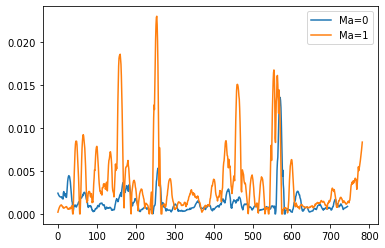

In [143]:
fps = 30.0
dt = 1/fps


fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ma0.xml"
lm_Ma0 = faceWareLandmarkObject(fileName)

fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ma1.xml"
lm_Ma1 = faceWareLandmarkObject(fileName)


mouth_Ma0 = lm_Ma0.getMouth()[0]
velocity_Ma0 = savgol_filter(get_average_velocity(mouth_Ma0, dt), 19, 2)
velocity_Ma0 = np.where(velocity_Ma0>0, velocity_Ma0, 0)
mouth_Ma1 = lm_Ma1.getMouth()[0]
velocity_Ma1 = savgol_filter(get_average_velocity(mouth_Ma1, dt), 19, 2)
velocity_Ma1 = np.where(velocity_Ma1>0, velocity_Ma1, 0)

plt.plot(velocity_Ma0, label="Ma=0")
plt.plot(velocity_Ma1, label="Ma=1")
plt.legend()
plt.show()

# 2.1b Raw Yannis Ps comparison

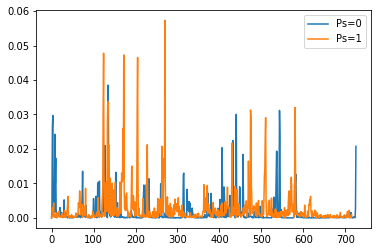

In [189]:
fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ps0.xml"
lm_Ps0 = faceWareLandmarkObject(fileName)

fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ps1.xml"
lm_Ps1 = faceWareLandmarkObject(fileName)


mouth_Ps0 = lm_Ps0.getMouth()[0]
velocity_Ps0 = savgol_filter(get_average_velocity(mouth_Ps0, dt), 21, 2)
velocity_Ps0 = get_average_velocity(mouth_Ps0, dt)
velocity_Ps0 = np.where(velocity_Ps0>0, velocity_Ps0, 0)

mouth_Ps1 = lm_Ps1.getMouth()[0]
velocity_Ps1 = savgol_filter(get_average_velocity(mouth_Ps1, dt), 21, 2)
velocity_Ps1 = get_average_velocity(mouth_Ps1, dt)

velocity_Ps1 = np.where(velocity_Ps1>0, velocity_Ps1, 0)

plt.plot(velocity_Ps0, label="Ps=0")
plt.plot(velocity_Ps1, label="Ps=1")
plt.legend()
plt.show()

# 2.2 Oh Canada Yannis comparison

## 2.2a automatically generate raw alignment

In [190]:
# generate raw word alignment

from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video
datapath = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\jali_sing_stuff"
files = ["Ma0_facecam", "Ma1_facecam", "Ps0_facecam", "Ps1_facecam"]
arrs = [velocity_Ma0, velocity_Ma1, velocity_Ps0, velocity_Ps1]
# for item in files:
#     get_wav_from_video(item+".mp4", datapath)
#     song = Minimal_song_data_structure(datapath+"\\"+item+".wav", datapath+"\\"+item+".txt", )
#     song.compute_self_phoneme_alignment()
#     song.write_textgrid(datapath, item)

## 2.2b after manually fixing alignment

In [191]:
i = 0
consonant_out = []
consonant_out.append(select_only_consonant(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps))
consonant_out.append(select_only_consonant(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps))
consonant_out.append(select_only_consonant(datapath+"\\"+files[2]+".TextGrid", arrs[2], fps))
consonant_out.append(select_only_consonant(datapath+"\\"+files[3]+".TextGrid", arrs[3], fps))

vowel_out = []
vowel_out.append(select_only_vowels(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[2]+".TextGrid", arrs[2], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[3]+".TextGrid", arrs[3], fps))

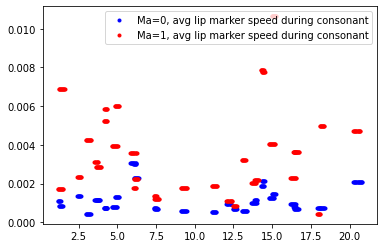

In [192]:
for i in range(len(consonant_out[0])):
    item = consonant_out[0][i]
    if i == 0:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=3, label="Ma=0, avg lip marker speed during consonant")
    else:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=3)
        
        
for i in range(len(consonant_out[1])):
    item = consonant_out[1][i]
    comparison_start_i = consonant_out[0][i][0][0]
    item_start_i = item[0][0]
    diff = item_start_i - comparison_start_i
    if i == 0:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro",  markersize=3, label="Ma=1, avg lip marker speed during consonant")
    else:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", markersize=3)        
plt.legend()

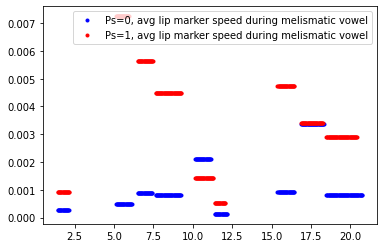

In [205]:
tripped = 0
for i in range(1, len(vowel_out[2])):
    item = vowel_out[2][i]
    if (item[0][-1] - item[0][0] >= 0.5):
        if tripped == 0:
            plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo", label="Ps=0, avg lip marker speed during melismatic vowel",markersize=3)
            tripped = 1
        else:
            plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo", markersize=3)

tripped = 0
for i in range(1, len(vowel_out[3])):
    item = vowel_out[3][i]
    comparison_start_i = vowel_out[2][i][0][0]
    item_start_i = item[0][0]
    diff = item_start_i - comparison_start_i
    if (item[0][-1] - item[0][0] >= 0.5):
        if tripped == 0:
            plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", label="Ps=1, avg lip marker speed during melismatic vowel", markersize=3)
            tripped = 1
        else:
            plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", markersize=3)
        
plt.legend()
    

# 3.0 Martin Ma comparison

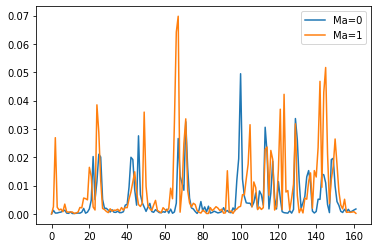

In [230]:
fps = 30.0
dt = 1/fps


fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Martin\\stress and strain\\landmark_comparison\\Ma0.xml"
lm_Ma0 = faceWareLandmarkObject(fileName)

fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Martin\\stress and strain\\landmark_comparison\\Ma1.xml"
lm_Ma1 = faceWareLandmarkObject(fileName)


mouth_Ma0 = lm_Ma0.getMouth()[0]
velocity_Ma0 = get_average_velocity(mouth_Ma0, dt)
velocity_Ma0 = np.where(velocity_Ma0>0, velocity_Ma0, 0)
mouth_Ma1 = lm_Ma1.getMouth()[0]
velocity_Ma1 = get_average_velocity(mouth_Ma1, dt)
velocity_Ma1 = np.where(velocity_Ma1>0, velocity_Ma1, 0)

plt.plot(velocity_Ma0, label="Ma=0")
plt.plot(velocity_Ma1, label="Ma=1")
plt.legend()
plt.show()

In [212]:
# generate raw word alignment

from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video
datapath = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Martin\\stress and strain\\jali_sing_stuff"
files = ["Ma0_facecam", "Ma1_facecam"]
arrs = [velocity_Ma0, velocity_Ma1, velocity_Ps0, velocity_Ps1]
# for item in files:
#     get_wav_from_video(item+".mp4", datapath)
#     song = Minimal_song_data_structure(datapath+"\\"+item+".wav", datapath+"\\"+item+".txt", )
#     song.compute_self_phoneme_alignment()
#     song.write_textgrid(datapath, item)

MoviePy - Writing audio in F:\MASC\Jali_sing\Revision\validation\faceware session Martin\stress and strain\jali_sing_stuff\Ma0_facecam.wav


MoviePy - Done.


['>', 'S', 'T', 'R', 'EH', 'S', '>', 'AH', 'N', 'D', '>', 'S', 'T', 'R', 'EY', 'N', '>', 'L', 'AY', 'K', '>', 'AE', 'N', '>', 'AH', 'B', 'JH', 'EH', 'K', 'SH', 'AH', 'N', '>', 'S', 'AH', 'S', 'T', 'EY', 'N', 'D', '>', 'OW', 'V', 'ER', '>', 'R', 'UW', 'L', 'D', '>', 'B', 'AY', '>', 'F', 'UW', 'L', '>', 'HH', 'UW', '>', 'K', 'AH', 'M', 'P', 'L', 'EY', 'N']
[[0.0191875, 0.5471875], [0.5471875, 0.7391875], [0.7391875, 0.8031875], [0.8031875, 0.9151875], [0.9151875, 0.9791875], [0.9791875, 1.1231875], [1.1231875, 1.1391875], [1.1391875, 1.1711874999999998], [1.1711874999999998, 1.2191874999999999], [1.2191874999999999, 1.2351874999999999], [1.2351874999999999, 1.2511875], [1.2511875, 1.3951874999999998], [1.3951874999999998, 1.4911874999999999], [1.4911874999999999, 1.5711875], [1.5711875, 1.9871874999999999], [1.9871874999999999, 2.0031875], [2.0031875, 2.0511875], [2.0511875, 2.0831875], [2.0831875, 2.1471875000000002], [2.1471875000000002, 2.1631875000000003], [2.1631875000000003, 2.1791

MoviePy - Done.


['>', 'S', 'T', 'R', 'EH', 'S', '>', 'AH', 'N', 'D', '>', 'S', 'T', 'R', 'EY', 'N', '>', 'L', 'AY', 'K', '>', 'AE', 'N', '>', 'AH', 'B', 'JH', 'EH', 'K', 'SH', 'AH', 'N', '>', 'S', 'AH', 'S', 'T', 'EY', 'N', 'D', '>', 'OW', 'V', 'ER', '>', 'R', 'UW', 'L', 'D', '>', 'B', 'AY', '>', 'F', 'UW', 'L', '>', 'HH', 'UW', '>', 'K', 'AH', 'M', 'P', 'L', 'EY', 'N']
[[0.0279375, 0.5719375], [0.5719375, 0.7319374999999999], [0.7319374999999999, 0.7959375], [0.7959375, 0.8759374999999999], [0.8759374999999999, 1.0359375], [1.0359375, 1.1319375], [1.1319375, 1.2119375], [1.2119375, 1.2599375], [1.2599375, 1.2919375], [1.2919375, 1.3079375], [1.3079375, 1.3239375], [1.3239375, 1.4839375], [1.4839375, 1.5799375], [1.5799375, 1.6599374999999998], [1.6599374999999998, 1.8359375], [1.8359375, 1.8679375], [1.8679375, 1.8839375], [1.8839375, 1.9319374999999999], [1.9319374999999999, 1.9959375], [1.9959375, 2.0119375], [2.0119375, 2.0279375], [2.0279375, 2.0599375], [2.0599375, 2.0919375000000002], [2.091937

In [228]:
i = 0
consonant_out = []
consonant_out.append(select_only_consonant(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps, delta=0))
consonant_out.append(select_only_consonant(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps, delta=0))

vowel_out = []
vowel_out.append(select_only_vowels(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps))

36


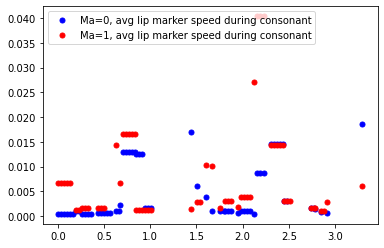

In [231]:
print(len(consonant_out[0]))

for i in range(len(consonant_out[0])-10):
    item = consonant_out[0][i]
    if i == 0:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=5, label="Ma=0, avg lip marker speed during consonant")
    else:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=5)
        
        
for i in range(len(consonant_out[1])-10):
    item = consonant_out[1][i]
    comparison_start_i = consonant_out[0][i][0][0]
    item_start_i = item[0][0]
    diff = item_start_i - comparison_start_i
    if i == 0:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro",  markersize=5, label="Ma=1, avg lip marker speed during consonant")
    else:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", markersize=5)        
plt.legend(loc='upper left')

# 4.0 Generate Lip Animations for Teaser Animation 

In [4]:
# generate raw word alignment

from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video
datapath = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\"
file_paths = ["reference_vocals", "reference_vocals", "reference_vocals", "reference_vocals"]
folder_paths = [datapath+"Mans_World\\", datapath+"rolling in the deep\\", datapath+"summum bolum\\", datapath+"tom sawyer\\"]
for i in range(1, 1):
    pass
#     get_wav_from_video(file_paths[i], folder_paths[i])
#     song = Minimal_song_data_structure(folder_paths[i]+file_paths[i]+".wav", folder_paths[i]+file_paths[i]+".txt", )
#     song.compute_self_phoneme_alignment()
#     song.write_textgrid(folder_paths[i], file_paths[i])

### 4.1 generate lip animation - Adele

In [5]:
file_dir = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\rolling in the deep\\"
# tim = Minimal_song_data_structure(dir+"rap.wav", dir+"rap.txt")
# tim.compute_self_phoneme_alignment()
# tim.write_textgrid(dir, "rap_alignment")
# j = JaliVoCa_animation(file_dir+"reference_vocals.wav", dir+"reference_vocals.TextGrid", dir + "jali_MVP.json")
# j.generate_curves()



### 4.1 generate head animation

In [43]:
file_dir = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\rolling in the deep\\"
file = "phone_cam.mov"

In [7]:
extract_landmarks_media_pipe(file, file_dir, save_annotated_video=True, image_mode=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 651/652.0 [00:21<00:00, 30.51it/s]


'F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\rolling in the deep\\phone_cam\\2D_mediapipe_landmark.npy'

In [44]:
lmPath = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\Ps1_phonecam\\raw_mediapipe_landmark.npy"
videoPath = file_dir+file

# lmPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/Child_in_time_2/raw_mediapipe_landmark.npy"
# lmPath = "E:/Facial Feature Motion Clip/rollingInTheDeep/raw_mediapipe_landmark.npy"
# lmPath = "/Volumes/KINGSTON/csc2521/raw_mediapipe_landmark.npy"
# outputPath = "/Volumes/EVAN_DISK/emp/child_in_time_motion.json"
outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
fps = 23.98
min_cutoff = 0.0001
beta = 1.5
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(file_dir+"phone_cam//raw_mediapipe_landmark.npy")
t_ref = 0

(652, 3)


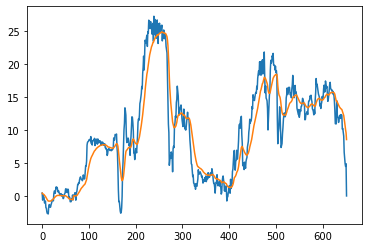

In [45]:
from scipy.spatial.transform import Rotation as Rot
fps = 23.98
min_cutoff = 0.01
beta = 0.001
t_segment = [0, data.shape[0]] 
r = Rot.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data
neutral_frame_num = 67
ref_frame = data[neutral_frame_num]
dataSegment, rotations = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices, True)
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,2])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [neutral_frame_num])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [neutral_frame_num])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [neutral_frame_num])
plt.plot(rotations[:,2])
print(np.array(rotations)[0:].shape)
start = 0
outputToFile(rotation_output_path, np.array(rotations)[0:], fps, start=0, angle=True)

### 4.2 generate lip animation - man's world

In [33]:
from util.jali_curve_generation import JaliVoCa_animation

file_dir = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\Mans_World\\"
# j = JaliVoCa_animation(file_dir+"reference_vocals.wav", file_dir+"reference_vocals.TextGrid", file_dir + "jali_MVP.json")
# j.generate_curves()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400.0 [00:14<00:00, 27.53it/s]


(228, 3)


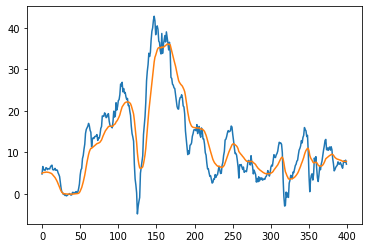

In [35]:
file = "phone_cam.mov"
extract_landmarks_media_pipe(file, file_dir, save_annotated_video=True, image_mode=False)

outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
fps = 23.98
min_cutoff = 0.0001
beta = 1.5
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(file_dir+"phone_cam//raw_mediapipe_landmark.npy")
t_ref = 0

from scipy.spatial.transform import Rotation as Rot
fps = 23.98
min_cutoff = 0.01
beta = 0.001
t_segment = [0, data.shape[0]] 
r = Rot.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data
neutral_frame_num = 29
ref_frame = data[neutral_frame_num]
dataSegment, rotations = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices, True)
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,2])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [neutral_frame_num])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [neutral_frame_num])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [neutral_frame_num])
plt.plot(rotations[:,2])
print(np.array(rotations)[172:].shape)
start = 0
outputToFile(rotation_output_path, np.array(rotations)[:], fps, start=0, angle=True)

### 4.3 generate lip animation - and I

In [9]:
# generate raw word alignment
from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video
from util.jali_curve_generation import JaliVoCa_animation

file_dir = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\and I\\"

# get_wav_from_video("reference.mp4", file_dir)
# song = Minimal_song_data_structure(file_dir+"reference_vocals"+".wav", file_dir+"reference"+".txt", )
# song.compute_self_phoneme_alignment()
# song.write_textgrid("reference_vocals", file_dir)


j = JaliVoCa_animation(file_dir+"reference_vocals.wav", file_dir+"reference_vocals.TextGrid", file_dir + "reference_vocals_jali_MVP.json")
j.generate_curves()

MoviePy - Writing audio in F:\MASC\Jali_sing\Revision\Lip Sync live performances\and I\head_modified\audio.mp3


MoviePy - Done.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299.0 [00:11<00:00, 26.33it/s]


(127, 3)


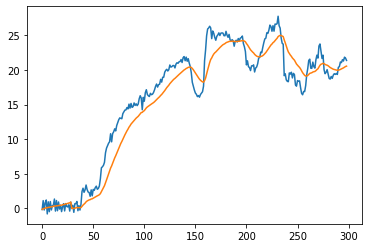

In [13]:
file = "head_modified.mp4"
extract_landmarks_media_pipe(file, file_dir, save_annotated_video=True, image_mode=False)

outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
fps = 23.98
min_cutoff = 0.0001
beta = 1.5
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(file_dir+"head_modified//raw_mediapipe_landmark.npy")
t_ref = 0

from scipy.spatial.transform import Rotation as Rot
fps = 23.98
min_cutoff = 0.01
beta = 0.001
t_segment = [0, data.shape[0]] 
r = Rot.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data
neutral_frame_num = 29
ref_frame = data[neutral_frame_num]
dataSegment, rotations = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices, True)
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,2])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [neutral_frame_num])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [neutral_frame_num])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [neutral_frame_num])
plt.plot(rotations[:,2])
print(np.array(rotations)[172:].shape)
start = 0
outputToFile(rotation_output_path, np.array(rotations)[:], fps, start=0, angle=True)

### 4.3 generate lip animation - Tom Sawyer

In [47]:
from util.jali_curve_generation import JaliVoCa_animation

file_dir = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\tom sawyer\\"
j = JaliVoCa_animation(file_dir+"reference_vocals.wav", file_dir+"reference_vocals.TextGrid", file_dir + "jali_MVP.json")
j.generate_curves()

In [48]:
te lip animation - man's world
1
from util.jali_curve_generation import JaliVoCa_animation
2
​
3
file_dir = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\Mans_World\\"
4
# j = JaliVoCa_animation(file_dir+"reference_vocals.wav", file_dir+"reference_vocals.TextGrid", file_dir + "jali_MVP.json")
5
# j.generate_curves()
file = "phone_cam.mov"
extract_landmarks_media_pipe(file, file_dir, save_annotated_video=True, image_mode=False)

outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
fps = 23.98
min_cutoff = 0.0001
beta = 1.5
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(file_dir+"phone_cam//raw_mediapipe_landmark.npy")
t_ref = 0

from scipy.spatial.transform import Rotation as Rot
fps = 23.98
min_cutoff = 0.01
beta = 0.001
t_segment = [0, data.shape[0]] 
r = Rot.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data
neutral_frame_num = 29
ref_frame = data[neutral_frame_num]
dataSegment, rotations = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices, True)
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,2])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [neutral_frame_num])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [neutral_frame_num])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [neutral_frame_num])
plt.plot(rotations[:,2])
print(np.array(rotations)[172:].shape)
start = 0
outputToFile(rotation_output_path, np.array(rotations)[:], fps, start=0, angle=True)

 36%|████████████████████████████████████████████████████████████████████▋                                                                                                                            | 143/402.0 [00:04<00:08, 29.22it/s]

KeyboardInterrupt: 

### 4.2 generate lip animation - Introduction Sentence

In [16]:
from util.jali_curve_generation import JaliVoCa_animation
# generate raw word alignment
from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video

file_dir = "F:\\MASC\\Jali_sing\\Revision\\Revision_submission_Video\\intro_sentence\\"

song = Minimal_song_data_structure(file_dir+"vocal_spoken.wav", file_dir+"vocal_spoken.txt")
song.compute_self_phoneme_alignment()
song.write_textgrid(file_dir, "vocal_spoken")



['>', 'V', 'OW', 'K', 'AH', 'L']
[[0.0, 0.8], [0.8, 1.072], [1.072, 3.008], [3.008, 3.088], [3.088, 3.12], [3.12, 3.136]]


In [18]:
j = JaliVoCa_animation(file_dir+"vocal_spoken.wav", file_dir+"vocal_spoken.TextGrid", file_dir + "jali_MVP.json")
j.generate_curves()

(215, 3)


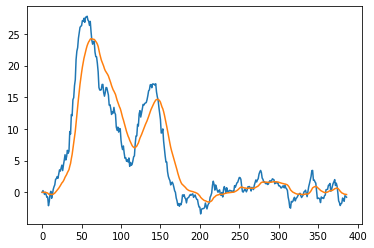

In [10]:
file = "IMG_2126.mp4"
file_dir = "F:/MASC/Jali_sing/Revision/Revision_submission_Video/intro_sentence/brow and head motion/"
# extract_landmarks_media_pipe(file, file_dir, save_annotated_video=True, image_mode=False)

outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
fps = 23.98
min_cutoff = 0.0001
beta = 1.5
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(file_dir+"IMG_2126/raw_mediapipe_landmark.npy")
t_ref = 0

from scipy.spatial.transform import Rotation as Rot
fps = 23.98
min_cutoff = 0.01
beta = 0.001
t_segment = [0, data.shape[0]] 
r = Rot.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data
neutral_frame_num = 0
ref_frame = data[neutral_frame_num]
dataSegment, rotations = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices, True)
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,2])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [neutral_frame_num])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [neutral_frame_num])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [neutral_frame_num])
plt.plot(rotations[:,2])
print(np.array(rotations)[172:].shape)
start = 0
outputToFile(rotation_output_path, np.array(rotations)[:], fps, start=0, angle=True)

### 4.3 generate paralingual animation - cry me a river

(734, 3)


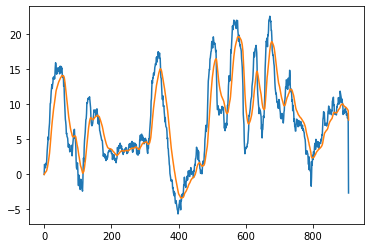

In [7]:
file = "phone cam_edited.mp4"
file_dir = "F:/MASC/Jali_sing/Revision/Lip Sync live performances/Cry me a river/"
# extract_landmarks_media_pipe(file, file_dir, save_annotated_video=True, image_mode=False)

outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
fps = 23.98
min_cutoff = 0.0001
beta = 1.5
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(file_dir+"phone cam_edited/raw_mediapipe_landmark.npy")
t_ref = 0

from scipy.spatial.transform import Rotation as Rot
fps = 23.98
min_cutoff = 0.01
beta = 0.001
t_segment = [0, data.shape[0]] 
r = Rot.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data
neutral_frame_num = 0
ref_frame = data[neutral_frame_num]
dataSegment, rotations = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices, True)
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,2])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [neutral_frame_num])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [neutral_frame_num])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [neutral_frame_num])
plt.plot(rotations[:,2])
print(np.array(rotations)[172:].shape)
start = 0
outputToFile(rotation_output_path, np.array(rotations)[:], fps, start=0, angle=True)

### 4.4 4 Styles of Yannis singing Oh Canada

In [13]:
from util.jali_curve_generation import JaliVoCa_animation
# generate raw word alignment
from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video

file_dir = "F:/MASC/Jali_sing/Revision/validation/faceware session Yannis/Oh Canada/Jali/"

get_wav_from_video("Ma1_facecam.mp4", file_dir)
song = Minimal_song_data_structure(file_dir+"Ma1_facecam.wav", file_dir+"Ma1_facecam.txt")
song.compute_self_phoneme_alignment()
song.write_textgrid(file_dir, "vocal_spoken")

MoviePy - Writing audio in F:/MASC/Jali_sing/Revision/validation/faceware session Yannis/Oh Canada/Jali/Ma1_facecam.wav


MoviePy - Done.
['>', 'OW', '>', 'K', 'AE', 'N', 'AH', 'D', 'AH', '>', 'W', 'IY', '>', 'S', 'T', 'AE', 'N', 'D', '>', 'AA', 'N', '>', 'G', 'AA', 'R', 'D', '>', 'F', 'AO', 'R', '>', 'DH', 'IY', 'Z', '>', 'OW', '>', 'K', 'AE', 'N', 'AH', 'D', 'AH', '>', 'W', 'IY', '>', 'S', 'T', 'AE', 'N', 'D', '>', 'AA', 'N', '>', 'G', 'AA', 'R', 'D', '>', 'F', 'AO', 'R', '>', 'DH', 'IY', 'Z']
[[0.07875, 2.15875], [2.15875, 3.27875], [3.27875, 3.32675], [3.32675, 3.51875], [3.51875, 4.19075], [4.19075, 4.414750000000001], [4.414750000000001, 4.65475], [4.65475, 4.73475], [4.73475, 5.16675], [5.16675, 5.18275], [5.18275, 5.358750000000001], [5.358750000000001, 5.72675], [5.72675, 5.74275], [5.74275, 5.80675], [5.80675, 5.99875], [5.99875, 6.478750000000001], [6.478750000000001, 6.526750000000001], [6.526750000000001, 6.542750000000001], [6.542750000000001, 6.60675], [6.60675, 6.86275], [6.86275, 7.07075], [7.07075, 7.08675], [7.08675, 7.19875], [7.19875, 8.19075], [8.19075, 8.39875], [8.39875, 8.41475], 

In [15]:
j = JaliVoCa_animation(file_dir+"Ma1_facecam.wav", file_dir+"Ma1_facecam.TextGrid", file_dir + "jali_MVP.json")
j.generate_curves()

In [5]:
from util.jali_curve_generation import JaliVoCa_animation
# generate raw word alignment
from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video

file_dir = "F:/MASC/Jali_sing/Revision/validation/faceware session Indian Classical singer/pia dana/"
get_wav_from_video("face_cam_pia_1.mp4", file_dir)

MoviePy - Writing audio in F:/MASC/Jali_sing/Revision/validation/faceware session Indian Classical singer/pia dana/face_cam_pia_1.wav


MoviePy - Done.


'F:/MASC/Jali_sing/Revision/validation/faceware session Indian Classical singer/pia dana/face_cam_pia_1.wav'

### 4.5 Piya dane

In [5]:
from util.jali_curve_generation import JaliVoCa_animation
# generate raw word alignment
from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video

file_dir = "F:/MASC/Jali_sing/Revision/validation/faceware session Indian Classical singer/pia dana/"

j = JaliVoCa_animation(file_dir+"face_cam_pia_1.wav", file_dir+"Perfect timing.TextGrid", file_dir + "pia_jali_MVP.json")
j.generate_curves()

(240, 3)


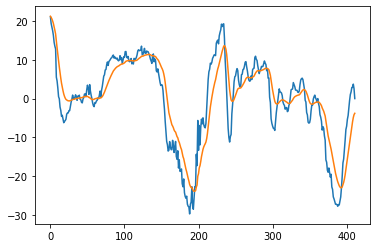

In [11]:
file = "head_cam_pia_1.mp4"
file_dir = "F:/MASC/Jali_sing/Revision/validation/faceware session Indian Classical singer/pia dana/"
# extract_landmarks_media_pipe(file, file_dir, save_annotated_video=True, image_mode=True)

outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
fps = 30
beta = 1.5
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(file_dir+"head_cam_pia_1/raw_mediapipe_landmark.npy")
t_ref = 65

from scipy.spatial.transform import Rotation as Rot
fps = 30
min_cutoff = 0.01
beta = 0.001
t_segment = [0, data.shape[0]] 
r = Rot.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data
neutral_frame_num = t_ref
ref_frame = data[neutral_frame_num]
dataSegment, rotations = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices, True)
# dataSegment, rotations = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,2])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [neutral_frame_num])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [neutral_frame_num])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [neutral_frame_num])
plt.plot(rotations[:,2])
print(np.array(rotations)[172:].shape)
start = 0
outputToFile(rotation_output_path, np.array(rotations)[:], fps, start=0, angle=True)

In [7]:
### 4.6 Song2Face
from util.jali_curve_generation import JaliVoCa_animation
# generate raw word alignment
from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video

file_dir = "F:/MASC/Jali_sing/Sig_videos/song2face5/"

get_wav_from_video("song2face.mp4", file_dir)
song = Minimal_song_data_structure(file_dir+"song2face.wav", file_dir+"song2face.txt")
song.compute_self_phoneme_alignment()
song.write_textgrid(file_dir, "Ma1_facecam")

MoviePy - Writing audio in F:/MASC/Jali_sing/Sig_videos/song2face5/song2face.wav


MoviePy - Done.


KeyError: 'wisdon'

In [ ]:
from util.jali_curve_generation import JaliVoCa_animation
# generate raw word alignment
from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video

file_dir = "F:/MASC/Jali_sing/Revision/validation/faceware session Indian Classical singer/pia dana/"

j = JaliVoCa_animation(file_dir+"face_cam_pia_1.wav", file_dir+"Perfect timing.TextGrid", file_dir + "pia_jali_MVP.json")
j.generate_curves()